### **PINN eikonal based velocity inversion for crosshole tomopgraph of the SEAM model**

In [27]:
'''
@Time    :   2025/03/03 17:20:43
@Author  :   ShaoboYang
@Email   :   yang0123@mail.ustc.edu.cn
'''

import numpy as np
import matplotlib.pyplot as plt
import scipy.io 
import time
import random
import os 
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sph2car import sph2car_ft

device = 'cuda'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
model_path = 'models'
fig_path = 'figs'
os.system(f'mkdir {model_path} {fig_path}')

256

In [28]:
#Model specifications

# Computational model parameters
wlat_ft = 36.65; wlon_ft = 119.18; theta_ft = 0
ymin = -50.; ymax = 50.; deltay_pred = 2
xmin = -70.; xmax = 70.; deltax_pred = 2 

In [29]:
# Creating grid, extending the velocity model, and prepare list of grid points for training (pred_grid)

## Grid for prediction
y_pred = np.arange(ymin, ymax+deltay_pred, deltay_pred)
ny_pred = y_pred.size

x_pred = np.arange(xmin, xmax+deltax_pred, deltax_pred)
nx_pred = x_pred.size

T_inp = np.round(np.arange(0.6, 10+0.01, 0.2), decimals=2)
nT_inp = T_inp.size

T_pred = np.round(np.arange(2, 2+0.01, 1), decimals=2)
nT_pred = T_pred.size

pred_Y, pred_X, pred_T = np.meshgrid(y_pred, x_pred, T_pred, indexing='ij') 
pred_grid = np.array([pred_Y.reshape(-1), pred_X.reshape(-1), pred_T.reshape(-1)])
pred_grid = pred_grid.transpose((1, 0))
# print('pred_grid:', np.array(pred_grid).shape)

In [30]:
# create input and target data
# data points and boundary condition

vs_ini = 2.6

T0 = []
T_data = []
tau0 = []
data = []            ## rz, rx, sz, sx, pz, px, T0, tau, v, t
sx = []
sy = []
with open('data_2s.dat', 'r') as f:
    for line in f.readlines():
        if line[0] == '#':
            items = line.split()
            evla0 = float(items[1])
            evlo0 = float(items[2])
            T_index = int(items[3])
            if T_index == 8:
                sx0, sy0, sz0 = sph2car_ft(evla0, evlo0, 0, wlat_ft, wlon_ft, theta_ft)
                if sx0 not in sx or sy0 not in sy:
                    sx.append(sx0)
                    sy.append(sy0)
                sv = vs_ini
                data.append([sy0, sx0, sy0, sx0, T_inp[T_index], 0, 0, 0, 1, sv, 0])
                data.append([sy0, sx0, sy0, sx0, T_inp[T_index], 0, 0, 0, 1, sv, 0])
        elif T_index == 8:
            stla0, stlo0, phasev = line.split()
            stla0 = float(stla0)
            stlo0 = float(stlo0)
            rx0, ry0, rz0 = sph2car_ft(stla0, stlo0, 0, wlat_ft, wlon_ft, theta_ft)
            dist = ((ry0 - sy0)**2 + (rx0 - sx0)**2)**0.5
            T_data0 = dist/float(phasev)
            T_data.append(T_data0)
            T00 = dist/sv
            # print(T_data0, T00, sy0, ry0, sx0, rx0)
            T0.append(T00)
            px0 = (rx0 - sx0)/T00/sv**2
            py0 = (ry0 - sy0)/T00/sv**2
            tau00 = T_data0/T00
            tau0.append(tau00)
            data.append([ry0, rx0, sy0, sx0, T_inp[T_index], py0, px0, T00, tau00, sv, T_data0])
            data.append([sy0, sx0, ry0, rx0, T_inp[T_index], -py0, -px0, T00, tau00, sv, T_data0])

T0 = np.array([T0])
T_data = np.array([T_data])
tau0 = np.array([tau0])
data = np.array(data)
T0 = T0.transpose(1, 0)
T_data = T_data.transpose(1, 0)
tau0 = tau0.transpose(1, 0)
ns = len(sx)
# data = data.transpose(1, 0)

print(T_data.shape, T0.shape, tau0.shape)
print(data.shape)      # 11*11*52: features, n_event, n_reveiver
print(ns)

(13549, 1) (13549, 1) (13549, 1)
(27680, 11)
291


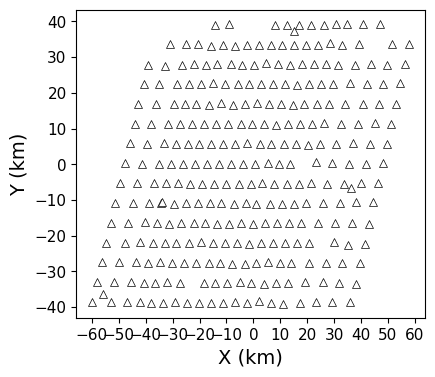

In [31]:
# Plot the source location

plt.style.use('default')

plt.figure(figsize=(4.5,4))

ax = plt.gca()
# im = ax.pcolor(x_pred, y_pred, vel, shading='auto', cmap="jet_r")
ax.plot(sx, sy, 'k^', markersize=6, markerfacecolor='w', markeredgewidth='0.5')
# ax.plot(sx, sy, 'y*', markersize=10)

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=11)

# plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_major_locator(plt.MultipleLocator(10))


plt.savefig(f"./{fig_path}/sta.pdf", format='pdf', bbox_inches="tight")

In [32]:
# points for prediction

T0_all_pred = np.zeros((ny_pred, nx_pred, ns, nT_pred))
px0_all_pred = np.zeros((ny_pred, nx_pred, ns, nT_pred))
py0_all_pred = np.zeros((ny_pred, nx_pred, ns, nT_pred))
ekl_data_pred = np.zeros((ny_pred, nx_pred, ns, nT_pred, 9))
for i in range(ny_pred):
    for j in range(nx_pred):
        for k in range(ns):
            for l in range(nT_pred):
                if vs_ini != 0:
                    T0_all_pred[i, j, k, l] = np.sqrt((sy[k]-y_pred[i])**2 + (sx[k]-x_pred[j])**2)/vs_ini
                    if T0_all_pred[i, j, k, l] != 0:
                        px0_all_pred[i, j, k, l] = (x_pred[j] - sx[k])/T0_all_pred[i, j, k, l]/vs_ini**2
                        py0_all_pred[i, j, k, l] = (y_pred[i] - sy[k])/T0_all_pred[i, j, k, l]/vs_ini**2
                ekl_data_pred[i, j, k, l] = np.array([y_pred[i], x_pred[j], sy[k], sx[k], T_pred[l], py0_all_pred[i, j, k, l], 
                                                      px0_all_pred[i, j, k, l], T0_all_pred[i, j, k, l], vs_ini])

# ekl_data shape: (101, 101, 11, 8): (nz, nx, ns, features)
# np.set_printoptions(suppress=True, threshold=1000)
# ekl_data = ekl_data.reshape(-1, 7)
print(ekl_data_pred.shape)
T0_all_pred = T0_all_pred.reshape(-1, 1)
px0_all_pred = px0_all_pred.reshape(-1, 1)
py0_all_pred = py0_all_pred.reshape(-1, 1)
ekl_data_pred = ekl_data_pred.reshape(-1, 9, 1)
ekl_data_pred = ekl_data_pred[:, :8, 0]
print(ekl_data_pred.shape, T0_all_pred.shape)

(51, 71, 291, 1, 9)
(1053711, 8) (1053711, 1)


In [33]:
import math
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import SGD, Adam, RMSprop
from torch.autograd import Variable, grad
from torch.cuda.amp import autocast
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler

def init_weights(m):
    if type(m) == torch.nn.Linear:
        stdv = (1. / math.sqrt(m.weight.size(1))/1.)*2        # m.weight.size(1) = 20 if nl = 10
        m.weight.data.uniform_(-stdv,stdv)
        m.bias.data.uniform_(-stdv,stdv)

def init_weights2(m):             # glorot_uniform 
    if type(m) == torch.nn.Linear: 
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.constant_(m.bias, 0)

        

In [34]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(1234)

In [35]:
def bearing(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return (90 - torch.rad2deg(torch.atan2(dy, dx)) + 360) % 360
    
def gradient_bearing(tdx, tdy):
    return (90 - torch.rad2deg(torch.atan2(tdy, tdx)) + 360) % 360

class NN_t(torch.nn.Module):
    def __init__(self, nl=10, activation=torch.nn.LeakyReLU()):
    # def __init__(self, nl=10, activation=torch.nn.ELU()):
            super(NN_t, self).__init__()
            self.act = activation
            self.sigmoid = torch.nn.Sigmoid()

            # Input Structure
            self.fc_t0  = Linear(5, 100)

            # Resnet Block
            self.fc_list_t = torch.nn.ModuleList([Linear(100, 100) for i in range(nl)])

            # Output structure
            self.fc_t1  = Linear(100, 1)

    def forward(self, xt):
        xt = self.act(self.fc_t0(xt))
        for i in range(len(self.fc_list_t)):
            xt = self.act(self.fc_list_t[i](xt))

        # tau = 5*self.sigmoid(self.fc_t1(xt))
        tau = self.act(self.fc_t1(xt))
        return tau

class NN_v(torch.nn.Module):
    def __init__(self, nl=10, activation=torch.nn.LeakyReLU()):
        super(NN_v, self).__init__()
        self.act = activation
        self.sigmoid = torch.nn.Sigmoid()

        # Input Structure
        self.fc_v0  = Linear(3, 50)

        # Resnet Block
        self.fc_list_v = torch.nn.ModuleList([Linear(50, 50) for i in range(nl)])

        # Output structure
        self.fc_v1  = Linear(50, 1)

    def forward(self, xv):
        xv = self.act(self.fc_v0(xv))
        for i in range(len(self.fc_list_v)):
            xv = self.act(self.fc_list_v[i](xv))

        v_iso = 5*self.sigmoid(self.fc_v1(xv))
        
        # v = 5*self.act(self.fc_v1(xv))
        return v_iso
# Data: [rz[j], rx[j], sz[i], sx[i], pz0[i, j], px0[i, j], T0[i, j], tau0[i, j], vs[i]])
# pair_loc: [rz, rx, sz, sx]
# factors: [pz0, px0, T0]
# st_loc: [rz, rx]


def PDELoss2(pair_loc, factors, tau_pred, v_iso_pred, device):
    dtau  = torch.autograd.grad(outputs=tau_pred, inputs=pair_loc, grad_outputs=torch.ones(tau_pred.size()).to(device), 
                        only_inputs=True, create_graph=True, retain_graph=True)[0]
    pz0 = torch.unsqueeze(factors[:, 0], dim=1)
    px0 = torch.unsqueeze(factors[:, 1], dim=1)
    T0 = torch.unsqueeze(factors[:, 2], dim=1)
    dtau_drz = torch.unsqueeze(dtau[:, 0], dim=1)
    dtau_drx = torch.unsqueeze(dtau[:, 1], dim=1)

    v_pred = v_iso_pred
    s_eikonal = dtau_drz**2 + dtau_drx**2
    s_pred = 1.0/v_pred**2
    pde_loss = F.mse_loss(s_eikonal, s_pred)
    loss = pde_loss
    return loss

###  without PDE loss ###
def DataLoss2(tau_pred, tau_obs, device):       
    t_loss = F.mse_loss(tau_pred, tau_obs)
    # loss_t = (torch.sum((tau_pred - tau_obs)**2)/len(tau_obs))**0.5
    loss = t_loss
    return loss


In [ ]:
nn_v = torch.load(f'./{model_path}/60_v.pt')
nn_t = torch.load(f'./{model_path}/60_t.pt')
nn_v.to(torch.device(device='cpu')); 
nn_t.to(torch.device(device='cpu')); 

RMS=0.6506828590925943 s


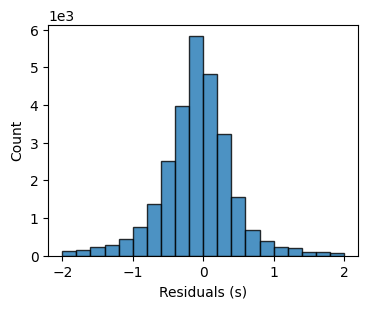

In [37]:
# calculate data residual 
data_tensor = torch.from_numpy(data.astype(np.float32))
pair_loc = data_tensor[:, :5]
tau_pred = nn_t.forward(pair_loc)
tt_pred = tau_pred.cpu().detach().numpy()
tt_label = data_tensor[:, 10:11].numpy()
diff = tt_pred - tt_label
diff = (diff.T)[0]
rms = np.mean(diff**2)**0.5
print(f'RMS={rms} s')

plt.figure(figsize=(4.0,3))
fontsize = 10
ax = plt.hist(diff, bins=20, range=(-2, 2), rwidth=1, alpha=0.8, ec='k', label='Initial')
plt.xlabel('Residuals (s)', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.ticklabel_format(style='sci', scilimits=(-1, 1), axis='y')
plt.tick_params(labelsize=fontsize)
plt.savefig(f"./{fig_path}/hist.pdf", format='pdf', bbox_inches="tight")

In [38]:
pred_grid = torch.from_numpy(pred_grid.astype(np.float32))

In [39]:
pair_loc = torch.from_numpy(ekl_data_pred[:, :5].astype(np.float32))
test_batch_size = 2000

data_size = len(pair_loc)
if data_size%test_batch_size == 0:
    batch_num = data_size//test_batch_size
else:
    batch_num = data_size//test_batch_size + 1

tt_pred = []
v_pred3_all = []
for i in range(batch_num):
    if (i+1)*test_batch_size < data_size:
        batch_pair_loc = pair_loc[i*test_batch_size:(i+1)*test_batch_size]
        batch_T0_all_pred = T0_all_pred[i*test_batch_size:(i+1)*test_batch_size]
    else:
        batch_pair_loc = pair_loc[i*test_batch_size:]
        batch_T0_all_pred = T0_all_pred[i*test_batch_size:]

    batch_pair_loc.requires_grad_()
    batch_tau_pred = nn_t.forward(batch_pair_loc)
    batch_tt_pred = batch_tau_pred.detach().numpy()
    tt_pred.extend(batch_tt_pred)

    dtau = torch.autograd.grad(outputs=batch_tau_pred, inputs=batch_pair_loc, grad_outputs=torch.ones(batch_tau_pred.size()), 
                               only_inputs=True, create_graph=True, retain_graph=True)[0]
    dtau_dry = torch.unsqueeze(dtau[:, 0], dim=1)
    dtau_drx = torch.unsqueeze(dtau[:, 1], dim=1)
    T0 = batch_T0_all_pred
    batch_v_pred3 = 1/((dtau_dry.detach().numpy())**2 + (dtau_drx.detach().numpy())**2)**0.5
    v_pred3_all.extend(batch_v_pred3)

tt_pred = np.array(tt_pred)
# tt_pred = tau_pred.detach().numpy()
# print(tt_pred.shape)
tt_pred = tt_pred.reshape((ny_pred, nx_pred, ns, nT_pred))
print(tt_pred.shape)

v_pred2 = nn_v.forward(pred_grid)
v_pred2 = v_pred2.detach().numpy()
v_pred2 = v_pred2.reshape(pred_Y.shape)

v_pred3_all = np.array(v_pred3_all)
v_pred3_all = v_pred3_all.reshape((ny_pred, nx_pred, ns, nT_pred))
# v_pred3_all = v_pred3_all.numpy()

vmax = 4
vmin = 0.5
v_pred3 = np.zeros((v_pred3_all.shape[0], v_pred3_all.shape[1], v_pred3_all.shape[3]))
v_std = np.zeros((v_pred3_all.shape[0], v_pred3_all.shape[1], v_pred3_all.shape[3]))
for i in range(v_pred3_all.shape[0]):
    for j in range(v_pred3_all.shape[1]):
        for l in range(v_pred3_all.shape[3]):
            tmp = v_pred3_all[i, j, :, l]
            valid = tmp[np.where((tmp<=vmax)&(tmp>=vmin))]
            v_pred3[i, j, l] = np.mean(valid)
            v_std[i, j, l] = (np.mean((valid - np.mean(valid))**2)/len(valid))**0.5
print(v_pred3.shape)


(51, 71, 291, 1)
(51, 71, 1)


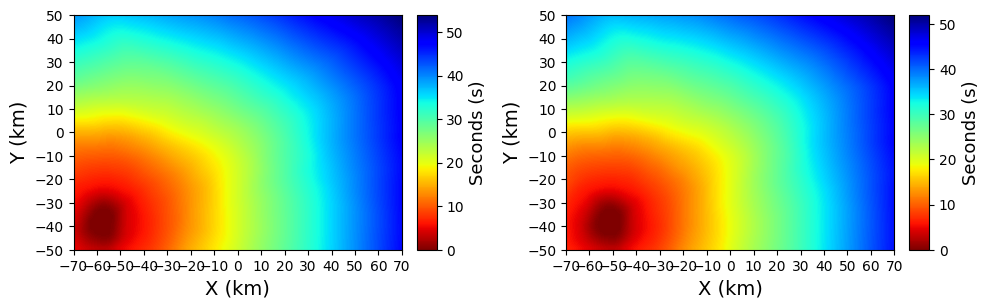

In [40]:
# Plot the PINN solution error

plt.style.use('default')
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
# plt.imshow(tt_pred[:,:,0], extent=[xmin,xmax,ymin,ymax], aspect=1, cmap="jet_r")
im = plt.imshow(tt_pred[:,:,0,0], extent=[xmin,xmax,ymax,ymin], aspect=1, interpolation='bilinear', cmap="jet_r")

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=10)

plt.gca().invert_yaxis()

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10))

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Seconds (s)',size=13)
cbar.ax.tick_params(labelsize=10)

plt.subplot(1,2,2)
# plt.imshow(T_data_all[:,:,0], extent=[xmin,xmax,ymin,ymax], aspect=1, cmap="jet_r")
im = plt.imshow(tt_pred[:,:,1,0], extent=[xmin,xmax,ymax,ymin], aspect=1, interpolation='bilinear', cmap="jet_r")

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=10)

plt.gca().invert_yaxis()

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10))

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Seconds (s)',size=13)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()


In [41]:
# print('Z:', z_pred)
# print('Y:', y_pred)
# print('X:', x_pred)
# Plot the PINN solution error
from sph2car import sph2car_ft
import math 

def read_fracture(filename):
    # 假设 fracture_lines 是一个包含所有断层线坐标的列表
    fracture_lines = []
    current_line = []

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            # 如果行以 '#' 开头，跳过该行
            if line.startswith('#'):
                continue
            if line.startswith('>'):
                # 遇到 > 符号说明一条线结束，将当前线加入到 fracture_lines 中
                if current_line:
                    fracture_lines.append(current_line)
                    current_line = []  # 重置 current_line
            else:
                # 将每行数据解析为坐标点，并添加到当前线的坐标点集中
                coords = list(map(float, line.split()))
                current_line.append(coords)
    # 确保将最后一条线加入到 fracture_lines 中
    if current_line:
        fracture_lines.append(current_line)

    # fracture_lines 现在包含了所有断层线的坐标点集
    return fracture_lines

def plot_fault_lines(ax, lines, centr_lat, centr_lon, theta):
    """绘制断层线"""
    for line in lines:
        filtered_x, filtered_y = [], []
        x_coords = [point[1] for point in line]
        y_coords = [point[0] for point in line]

        # 筛选符合条件的坐标
        for j in range(len(x_coords)):
            if 115 <= y_coords[j] <= 121 and 35 <= x_coords[j] <= 40:
                filtered_x.append(x_coords[j])
                filtered_y.append(y_coords[j])

        # 转换为笛卡尔坐标
        for k in range(len(filtered_x)):
            filtered_x[k], filtered_y[k], _ = sph2car_ft(filtered_x[k], filtered_y[k], 0, centr_lat, centr_lon, theta)
        
        ax.plot(filtered_x, filtered_y, color='black', linestyle='-', linewidth=0.8, label='Faults', alpha=1.0)

def plot_structures(ax, lines, centr_lat, centr_lon, theta):
    """绘制断层线"""
    for line in lines:
        filtered_x, filtered_y = [], []
        x_coords = [point[1] for point in line]
        y_coords = [point[0] for point in line]

        # 筛选符合条件的坐标
        for j in range(len(x_coords)):
            if 115 <= y_coords[j] <= 121 and 35 <= x_coords[j] <= 40:
                filtered_x.append(x_coords[j])
                filtered_y.append(y_coords[j])

        # 转换为笛卡尔坐标
        for k in range(len(filtered_x)):
            filtered_x[k], filtered_y[k], _ = sph2car_ft(filtered_x[k], filtered_y[k], 0, centr_lat, centr_lon, theta)
        
        ax.plot(filtered_x, filtered_y, color='black', linestyle='--', dashes=(7, 6), linewidth=0.8, label='Structures', alpha=1.0)

fracture_lines0 = read_fracture('faultXXW.dat')
structures = read_fracture('structure.dat')
jingzhi = read_fracture('jingzhi.dat')

centr_lat = 36.65; centr_lon = 119.18; theta_ft = 0


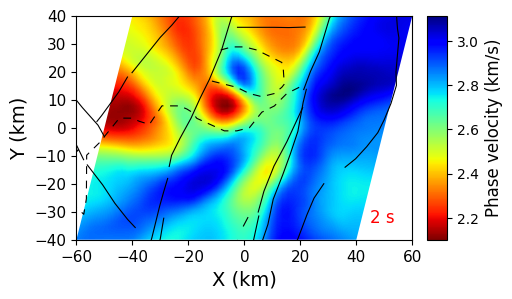

In [42]:
# Plot the Eiknoal tomo result
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.patches import Polygon
# from shapely.geometry import Point
# from shapely.geometry.polygon import Polygon
from scipy.ndimage import gaussian_filter

plt.style.use('default')

plt.figure(figsize=(13.5, 4))

verts = [(-60, -40), (-40, 40), (60, 40), (40, -40), (-60, -40)]
codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
path = Path(verts, codes)

ax = plt.subplot(1,3,1)
# im = ax.pcolor(pred_X, pred_Y, vel_avg, shading='auto', cmap="jet_r")
im = ax.imshow(gaussian_filter(v_pred3[:, :, 0], 0.8), extent=[xmin,xmax,ymax,ymin], aspect=1, interpolation='bilinear', cmap="jet_r")
# ax.scatter(sx, sy, marker='*', color='violet', s=60)
plot_fault_lines(ax, fracture_lines0, centr_lat, centr_lon, theta_ft)
# plot_fault_lines(ax, jingzhi, centr_lat, centr_lon, theta_ft)
plot_structures(ax, structures, centr_lat, centr_lon, theta_ft)
# ax.plot(sx, sy, 'k^', markersize=7, markerfacecolor='w', markeredgewidth='0.5')

im.set_clip_path(path, im.get_transform())
plt.text(45, -34, '2 s', fontsize=12, color='r')

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.gca().invert_yaxis()

plt.xlim((-60, 60))
plt.ylim((-40, 40))

# ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
# cbar.mappable.set_clim(1.93, 2.95)

cbar.set_label('Phase velocity (km/s)',size=12)
cbar.ax.tick_params(labelsize=10)
# im.set_clip_path(path, im.get_transform())


plt.tight_layout()
# 
plt.savefig(f"./{fig_path}/vel_inv.pdf", format='pdf', bbox_inches="tight")